In [2]:
import logging, itertools

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import colors
import astropy.io.ascii as at
from astropy.io import fits
from astropy.wcs import WCS
from scipy.linalg import cho_solve, cho_factor
import photutils

logging.basicConfig(level=logging.DEBUG)

In [27]:
filename = "tpf/ktwo202521690-c02_lpd-targ.fits"

In [28]:
hdu = fits.open(filename,mode='readonly',memmap=True)
hdu.info()
# Extension 0 is just the header
# Extension 1 is the data
# Extension 2 is the aperture mask

table = hdu[1].data[:]
times = table['TIME']
pixels = table['FLUX']
maskmap = hdu[2].data
maskheader = hdu[2].header

# Object coordinates
ra = hdu[0].header["RA_OBJ"]
dec = hdu[0].header["DEC_OBJ"]

hdu.close()

Filename: tpf/ktwo202521690-c02_lpd-targ.fits
No.    Name         Type      Cards   Dimensions   Format
0    PRIMARY     PrimaryHDU      54   ()              
1    TARGETTABLES  BinTableHDU    274   3856R x 12C   [D, E, J, 210J, 210E, 210E, 210E, 210E, 210E, J, E, E]   
2    APERTURE    ImageHDU        48   (14, 15)     int32   


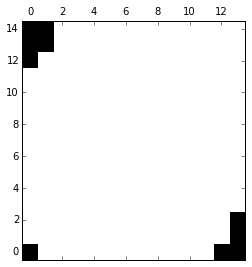

In [29]:
m = plt.matshow(maskmap, alpha=1, cmap="cubehelix", origin="lower")

In [30]:
num_steps = np.shape(pixels)[0]
print num_steps, "timepoints"
print maskmap.shape
print maskmap.shape[0]

3856 timepoints
(15, 14)
15


In [31]:
# Below is adapted from code DFM gave me in demo.ipynb
# These are some useful things to pre-compute and use later.
_x, _y = np.meshgrid(range(-1, 2), range(-1, 2), indexing="ij")
_x, _y = _x.flatten(), _y.flatten()
_AT = np.vstack((_x*_x, _y*_y, _x*_y, _x, _y, np.ones_like(_x)))
_ATA = np.dot(_AT, _AT.T)
factor = cho_factor(_ATA, overwrite_a=True)

# This function finds the centroid and second derivatives in a 3x3 patch.
def fit_3x3(img):
    a, b, c, d, e, f = cho_solve(factor, np.dot(_AT, img.flatten()))
    m = 1. / (4 * a * b - c*c)
    x = (c * e - 2 * b * d) * m
    y = (c * d - 2 * a * e) * m
    dx2, dy2, dxdy = 2 * a, 2 * b, c
    return [x, y, dx2, dy2, dxdy]

# This function finds the centroid in an image.
# You can provide an estimate of the centroid using WCS.
def find_centroid(img, init=None):
    if init is None:
        xi, yi = np.unravel_index(np.argmax(img), img.shape)
    else:
        xi, yi = map(int, map(np.round, init))
        ox, oy = np.unravel_index(np.argmax(img[xi-1:xi+2, yi-1:yi+2]), (3, 3))
        xi += ox - 1
        yi += oy - 1
    assert (xi >= 1 and xi < img.shape[0] - 1), "effed, x"
    assert (yi >= 1 and yi < img.shape[1] - 1), "effed, y"
    pos = fit_3x3(img[xi-1:xi+2, yi-1:yi+2])
    pos[0] += xi
    pos[1] += yi
    return pos

In [32]:
# Use the object position in the header to find the intended pixel coordinates for it
# Then find the centroid position using the object coordinates as a starting guess
wcs = WCS(hdu[2].header)
init = wcs.wcs_world2pix(ra, dec, 0.0)[::-1]
coords = find_centroid(pixels[100], init=init)

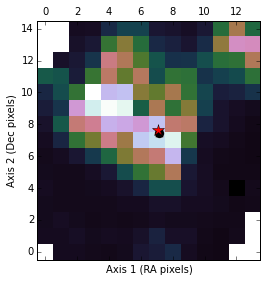

In [33]:
# Plot it!
m = plt.matshow(pixels[100], alpha=1, cmap="cubehelix", origin="lower", norm=colors.LogNorm())
plt.plot(init[0], init[1], "ko", mec="w", ms=10)
plt.plot(coords[0],coords[1], "r*", ms=12)
plt.xlim(-0.5,maskmap.shape[1]-0.5)
plt.ylim(-0.5,maskmap.shape[0]-0.5)
plt.ylabel("Axis 2 (Dec pixels)")
plt.xlabel("Axis 1 (RA pixels)")

Test that photutils is working (from Ann Marie): center on a pixel, and use a circular aperture with radius 0.5 pixels. The output flux from photutils should be equal to the pixel flux times the ratio of the circle's area to the pixel's. 

In [34]:
ap_center = [7,7]
print pixels[100][7,7] * (np.pi * 0.5 **2 / 1.0)
apertures = photutils.CircularAperture(ap_center, r=0.5)
photutils.aperture_photometry(pixels[100],apertures)

7183.88973844


aperture_sum,xcenter [1],ycenter [1]
,,
float64,float64,float64
7183.88973844,7.0,7.0


In [35]:
def calc_bkgd(image, mask, ap_center, bkgd_radius, 
              iterations=3, clip_at = 3):
    """Calculate background flux level for the image. 
    """
    
    # Calculate the distance of each pixel from the star's centroid
    image_shape = np.shape(image)
    center_dist = np.zeros_like(image)
    for i in range(image_shape[0]):
        for j in range(image_shape[1]):
            sq_sub = [(ap_center[0] - i)**2, 
                      (ap_center[1] - j)**2]
            center_dist[i,j] = np.sqrt(np.sum(sq_sub))
            
    # Mask out the area near the star
    bkgd_mask = np.zeros_like(image)
    bkgd_mask[center_dist>bkgd_radius] = 1
    # Mask out the areas that weren't observed
    bkgd_mask[mask==0] = 0
    
    background = image[bkgd_mask==1]
    bkgd_points = background.flatten()
    # Iterativelyi compute the median background level,
    # Removing 3-sigma outliers (or whatever level specified by clip_at) 
    for i in range(iterations):
#        logging.debug("%d %f",i,len(bkgd_points))
        med, stdev = np.median(bkgd_points), np.std(bkgd_points)
        bad_points = np.where(abs(bkgd_points - med) >= (clip_at * stdev))[0]
        bkgd_points = np.delete(bkgd_points, bad_points)
    
    # The background flux is the median of remaining background points
    bkgd_flux = np.median(bkgd_points)
    return bkgd_flux

In [36]:
calc_bkgd(pixels[100], maskmap, ap_center, 3)

353.55209

In [37]:
def get_flux(image, ap_center, ap_radii):
    """
    Calculate flux in a circular aperture at the given set of aperture radii.
    """
    
    ap_fluxes = np.zeros(len(ap_radii))
    bkgd_fluxes = np.zeros(len(ap_radii))
    
    # Compute fluxes and background levels for every given radius
    for i, rad in enumerate(ap_radii):
        # The background radius must be greater than the aperture radius by at least one pixel
        # including diagonals (hence the sqrt(2))
        bkgd_radius = np.ceil(rad + np.sqrt(2))
        # Calculate the background level
        bkgd_fluxes[i] = calc_bkgd(image, maskmap, ap_center, bkgd_radius)
        # Subtract the background level from every pixel in the image
        bkgd_subtracted = image - bkgd_fluxes[i]
        
        # Now do the aperture photometry itself
        aperture = photutils.CircularAperture(ap_center, r=rad)
        phot_table = photutils.aperture_photometry(bkgd_subtracted,aperture)
        ap_fluxes[i] = phot_table["aperture_sum"][0]
        
    return ap_fluxes, bkgd_fluxes

In [38]:
get_flux(pixels[100], ap_center, np.arange(1,6,1))

(array([  22478.846995  ,   55621.47572944,   84104.95552424,
         122733.88723006,  157708.99771712]),
 array([ 353.55209351,  343.49438477,  338.60574341,  338.77346802,
         338.68960571]))

In [39]:
def make_lc(image_list, times, start_center, ap_radii,
            output_filename):
    """
    Make a lightcurve by computing aperture photometry for 
    all images in a target pixel file.
    """
    
    # Open the output file and write the header line
    f = open(output_filename,"w")
    f.write("i,t,x,y")
    for r in ap_radii:
        f.write(",flux_{0:.1f},bkgd_{0:.1f}".format(r))
        
    # Do aperture photometry at every step, and save the results
    for i, time in enumerate(times):
        f.write("\n{0},{1:.6f}".format(i,time))
        
        # Find the actual centroid in this image, using start_center as a guess
        # (I should make a flag if the centroid has moved more than a pixel or two)
        coords = find_centroid(image_list[i], init=start_center)
        
        # Write out the centroid pixel coordinates
        f.write(",{0:.6f},{1:.6f}".format(coords[0],coords[1]))
        
        # Now run the aperture photometry on the image
        ap_fluxes, bkgd_fluxes = get_flux(image_list[i], 
                                          coords[:2], ap_radii)
        
        # Write out the fluxes and background level for each aperture
        for i, r in enumerate(ap_radii):
            f.write(",{0:.6f},{1:.6f}".format(ap_fluxes[i],
                                              bkgd_fluxes[i]))
            
    f.close()

In [40]:
# Find the object RA/Dec from the header in pixel coordinates
wcs = WCS(maskheader)
init = wcs.wcs_world2pix(ra, dec, 0.0)[::-1]
print init

[array(7.150192405523603), array(7.479072059681394)]


In [41]:
make_lc(pixels, times, init, np.array([2,3,5]),
       "test_lc.csv")

/home/stephanie/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:12: RuntimeWarning: divide by zero encountered in double_scalars
/home/stephanie/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:13: RuntimeWarning: invalid value encountered in double_scalars
/home/stephanie/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:14: RuntimeWarning: invalid value encountered in double_scalars
/home/stephanie/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:17: RuntimeWarning: invalid value encountered in greater


In [42]:
data = at.read("test_lc.csv")
data.dtype
data.dtype.names

('i',
 't',
 'x',
 'y',
 'flux_2.0',
 'bkgd_2.0',
 'flux_3.0',
 'bkgd_3.0',
 'flux_5.0',
 'bkgd_5.0')

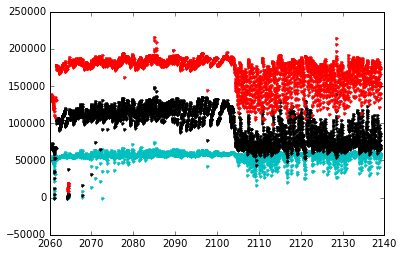

In [43]:
plt.plot(data["t"],data["flux_2.0"],"c.")
plt.plot(data["t"],data["flux_3.0"],"k.")
plt.plot(data["t"],data["flux_5.0"],"r.")

In [44]:
sources100 = photutils.daofind(pixels[100], fwhm=2.5, threshold = 1e3)
print sources100
sources0 = photutils.daofind(pixels[0], fwhm=2.5, threshold = 1e3)
print sources0

 id   xcentroid     ycentroid   ...      peak          flux          mag      
--- ------------- ------------- ... ------------- ------------- --------------
  1 7.35172125082 7.23239132016 ...     9146.8125 8.94358384719 -2.37877895727
  2  3.9019818012 9.19275561394 ... 15866.9482422 12.7014641998 -2.75963447113
  3 12.3001819225 12.9588449298 ... 4042.70458984 3.82999272956 -1.45799487388
 id   xcentroid     ycentroid   ...      peak          flux          mag      
--- ------------- ------------- ... ------------- ------------- --------------
  1  5.2143501865 5.73619170668 ... 14023.6767578 11.0162702786 -2.60508645643
  2 10.4332542303 11.6044190292 ...   5033.328125 3.43290322674 -1.33915390218


In [45]:
ra, dec

(243.326865, -29.374343)

In [46]:
np.shape(pixels)

(3856, 15, 14)

In [47]:
coadd = np.sum(pixels,axis=0)
print np.shape(coadd)
coords = find_centroid(coadd, init=init)

(15, 14)


In [48]:
sources = photutils.daofind(coadd, fwhm=2.5, threshold = 3e4)

<Row 0 of table
 values=(1, 7.351721250816799, 7.232391320159741, 0.47720492347865284, -0.7930953256817334, -0.64508935125921, 25.0, 0.0, 9146.8125, 8.943583847186048, -2.3787789572717095)
 dtype=[('id', '<i8'), ('xcentroid', '<f8'), ('ycentroid', '<f8'), ('sharpness', '<f8'), ('roundness1', '<f8'), ('roundness2', '<f8'), ('npix', '<f8'), ('sky', '<f8'), ('peak', '<f8'), ('flux', '<f8'), ('mag', '<f8')]>
<Row 1 of table
 values=(2, 3.9019818011968015, 9.192755613935345, 0.6410202705015777, -0.7747422608200595, -0.4512475958128941, 25.0, 0.0, 15866.9482421875, 12.701464199753186, -2.75963447113389)
 dtype=[('id', '<i8'), ('xcentroid', '<f8'), ('ycentroid', '<f8'), ('sharpness', '<f8'), ('roundness1', '<f8'), ('roundness2', '<f8'), ('npix', '<f8'), ('sky', '<f8'), ('peak', '<f8'), ('flux', '<f8'), ('mag', '<f8')]>
<Row 2 of table
 values=(3, 12.30018192245379, 12.958844929798271, 0.6347486817290514, -0.4139978768627857, -0.2417790068076368, 25.0, 0.0, 4042.70458984375, 3.829992729558168,

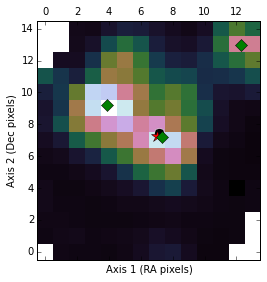

In [50]:
m = plt.matshow(coadd, alpha=1, cmap="cubehelix", origin="lower",norm=colors.LogNorm())
plt.plot(init[0], init[1], "ko", mec="w", ms=10)
plt.plot(coords[0],coords[1], "r*", ms=12)
plt.xlim(-0.5,maskmap.shape[1]-0.5)
plt.ylim(-0.5,maskmap.shape[0]-0.5)
# I remain unconvinced that these are labelled right...but the coordinates are plotting right, 
# and this matches the DSS images (except East and West are flipped)!
plt.ylabel("Axis 2 (Dec pixels)")
plt.xlabel("Axis 1 (RA pixels)")
for source in sources100:
    plt.plot(source["xcentroid"], source["ycentroid"], "gD", ms=9)

Filename: vanderburg/hlsp_k2sff_k2_lightcurve_202521690-c02_kepler_v1_llc.fits
No.    Name         Type      Cards   Dimensions   Format
0    PRIMARY     PrimaryHDU      25   ()              
1    BESTAPER    BinTableHDU    239   3529R x 6C   [D, D, D, D, I, J]   
2    CIRC_APER0  BinTableHDU    239   3529R x 6C   [D, D, D, D, I, J]   
3    CIRC_APER1  BinTableHDU    239   3529R x 6C   [D, D, D, D, I, J]   
4    CIRC_APER2  BinTableHDU    239   3529R x 6C   [D, D, D, D, I, J]   
5    CIRC_APER3  BinTableHDU    239   3529R x 6C   [D, D, D, D, I, J]   
6    CIRC_APER4  BinTableHDU    239   3529R x 6C   [D, D, D, D, I, J]   
7    CIRC_APER5  BinTableHDU    239   3529R x 6C   [D, D, D, D, I, J]   
8    CIRC_APER6  BinTableHDU    239   3529R x 6C   [D, D, D, D, I, J]   
9    CIRC_APER7  BinTableHDU    239   3529R x 6C   [D, D, D, D, I, J]   
10   CIRC_APER8  BinTableHDU    239   3529R x 6C   [D, D, D, D, I, J]   
11   CIRC_APER9  BinTableHDU    239   3529R x 6C   [D, D, D, D, I, J]   
12   

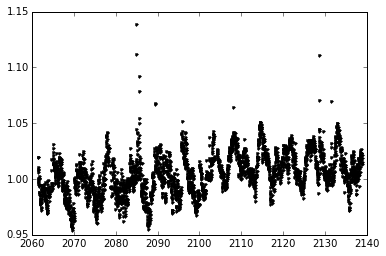

In [26]:
epic = "202521690"
vfile = "hlsp_k2sff_k2_lightcurve_{}-c02_kepler_v1_llc.fits".format(epic)
vanderburg = fits.open("vanderburg/"+vfile)
print vanderburg.info()
print np.asarray(vanderburg[1].data)
vd = np.asarray([np.asarray(vanderburg[1].data[i]) for i in range(len(vanderburg[1].data))])
plt.plot(vd[:,0], vd[:,1], 'k.')
vanderburg.close()